## Step 1: Importing Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import time
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

## Step 2: Loading dataset

In [5]:
data_dir = r"C:\COMP6721\sign_alphabets\dataset5\B";

### Transforming Dataset

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(data_dir, transform = transform)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

print("Number of classes: ",len(dataset.classes))
print("Number of images: ",len(dataset.samples))

Number of classes:  24
Number of images:  27820


In [8]:
# Splitting dataset into train, validation and test

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(0.1 * len(dataset))
extra_size = int(0 * len(dataset))
train_ds, val_ds, test_ds, extra_ds = random_split(dataset, [train_size, val_size, test_size, extra_size])
len(train_ds), len(val_ds), len(test_ds)

(19474, 5564, 2782)

In [9]:
from torch.utils.data import DataLoader
batch_size = 64

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

# show_batch(train_dl)

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'train_loss': loss.detach(), 'train_acc': acc}

    def testing_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def training_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
       
    def testing_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
       
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['test_loss'], result['val_loss'], result['train_acc'], result['test_acc'], result['val_acc']))

In [13]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(num_classes=24)

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
from torch.nn.modules import loss
from torch.optim.adam import Adam
num_epochs = 10
lr =  0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss();

In [18]:
from torch.autograd import Variable
#Model Training and saving best Model
best_accuracy = 0.0
train_acc_list = []
test_acc_list = []
val_acc_list = []
train_loss_list = []
test_loss_list = []
val_loss_list = []
epo = []
t1 = time.time()
for epoch in range(num_epochs):
  #evaluation and training on training dataset
  model.train()
  train_acc = 0.0
  train_loss = 0.0
  t2 = time.time()

  for i, (images, labels) in enumerate(train_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())
      
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    # scheduler.step()

    train_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)

    train_acc += int(torch.sum(prediction==labels.data))

  train_acc = (train_acc / train_size)*100
  train_loss = train_loss / train_size
      
  #Evaluation on testing dataset
  model.eval()

  val_acc = 0.0
  correct2 = 0
  total2 = 0
  val_loss = 0.0

  for i, (images, labels) in enumerate(val_dl):
    if(torch.cuda.is_available()):
      images = Variable(images.cuda())
      labels = Variable(labels.cuda())

    outputs = model(images)
    val_loss += loss.cpu().data*images.size(0)
    _,prediction=torch.max(outputs.data,1)
    val_acc += int(torch.sum(prediction==labels.data))
    total2 += labels.size(0)
    correct2 += (prediction == labels).sum().item()

  val_loss = val_loss / val_size
  val_acc = (val_acc / val_size)*100
  print('Epoch[{}]({:.0f} sec)  Train Loss: {:.4f}, Train Accuracy:  {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}\n'.format(epoch+1,time.time()-t2,train_loss,train_acc,val_loss,val_acc))
  train_acc_list.append(train_acc)
  # test_acc_list.append(test_acc)
  val_acc_list.append(val_acc)
  train_loss_list.append(train_loss)
  # test_loss_list.append(test_loss)
  val_loss_list.append(val_loss)
  epo.append(epoch+1)

  if(val_acc>best_accuracy):
    torch.save(model.state_dict(), 'best_checkpoint.model')
    best_accuracy = val_acc

torch.save(model.state_dict(), 'Resnet18-dataset3-batch_size'+str(batch_size)+ 'lr-' + str(lr)+'epochs-'+str(num_epochs)+'.pth')

print("######## Training Finished in {:.0f} seconds ###########".format(time.time()-t1))
# print('Test Accuracy of the model on the {} test images: {} %'.format(total1, (correct1 / total1) * 100))
# print('Test Accuracy of the model on the {} validation images: {} %'.format(total2, (correct2 / total2) * 100))

Epoch[1](110 sec)  Train Loss: 1.2824, Train Accuracy:  61.0866, Val Loss: 0.7408, Val Accuracy: 64.5938

Epoch[2](60 sec)  Train Loss: 0.5051, Train Accuracy:  83.9735, Val Loss: 0.3575, Val Accuracy: 58.7527

Epoch[3](60 sec)  Train Loss: 0.3380, Train Accuracy:  89.1086, Val Loss: 0.2383, Val Accuracy: 64.9712

Epoch[4](60 sec)  Train Loss: 0.2529, Train Accuracy:  91.6453, Val Loss: 0.1763, Val Accuracy: 90.1869

Epoch[5](60 sec)  Train Loss: 0.2023, Train Accuracy:  93.1961, Val Loss: 0.0843, Val Accuracy: 92.9367

Epoch[6](61 sec)  Train Loss: 0.1712, Train Accuracy:  94.1204, Val Loss: 0.2820, Val Accuracy: 89.9533

Epoch[7](61 sec)  Train Loss: 0.1518, Train Accuracy:  94.7879, Val Loss: 0.1722, Val Accuracy: 93.1344

Epoch[8](61 sec)  Train Loss: 0.1216, Train Accuracy:  95.7995, Val Loss: 0.1713, Val Accuracy: 92.2178

Epoch[9](60 sec)  Train Loss: 0.1188, Train Accuracy:  95.8457, Val Loss: 0.0281, Val Accuracy: 92.0561

Epoch[10](60 sec)  Train Loss: 0.0999, Train Accuracy:

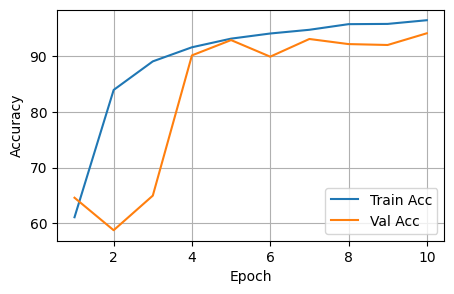

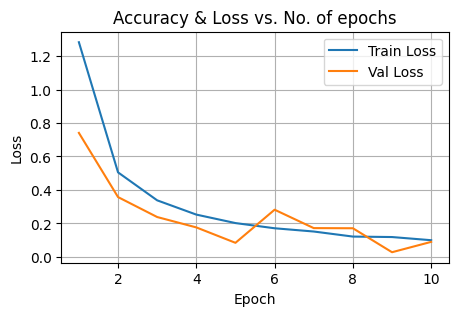

In [19]:
plt.rcParams["figure.figsize"] = (5,3)
fig, ax = plt.subplots()
plt.plot(epo, train_acc_list, label='Train Acc')
plt.plot(epo, val_acc_list, label='Val Acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

fig, ax = plt.subplots()
plt.plot(epo, train_loss_list, label='Train Loss')
plt.plot(epo, val_loss_list, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Accuracy & Loss vs. No. of epochs');

plt.grid()
plt.show()

# New Section

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy: 93.13443565780014


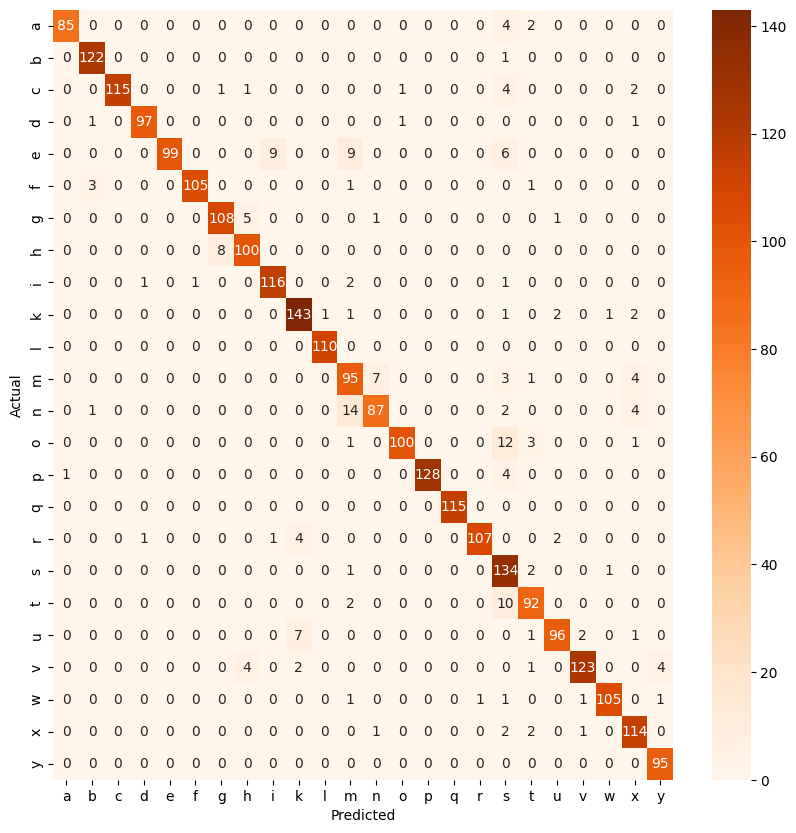

              precision    recall  f1-score   support

           a       0.99      0.93      0.96        91
           b       0.96      0.99      0.98       123
           c       1.00      0.93      0.96       124
           d       0.98      0.97      0.97       100
           e       1.00      0.80      0.89       123
           f       0.99      0.95      0.97       110
           g       0.92      0.94      0.93       115
           h       0.91      0.93      0.92       108
           i       0.92      0.96      0.94       121
           k       0.92      0.95      0.93       151
           l       0.99      1.00      1.00       110
           m       0.75      0.86      0.80       110
           n       0.91      0.81      0.85       108
           o       0.98      0.85      0.91       117
           p       1.00      0.96      0.98       133
           q       1.00      1.00      1.00       115
           r       0.99      0.93      0.96       115
           s       0.72    

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from torchvision.models import resnet18

test_model = resnet18(num_classes=24)
test_model.load_state_dict(torch.load('/content/Resnet18-dataset3-batch_size64lr-0.001epochs-10.pth'))
test_model.eval()

to_device(test_model, device)

# print(test_model)

test_preds = []
test_labels = []

for data in test_dl:
    images, labels = data[0].to(device), data[1].to(device)
    output = test_model(images)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    test_preds.extend(output) 
    labels = labels.data.cpu().numpy()
    test_labels.extend(labels) 

accuracy = accuracy_score(test_preds, test_labels)*100
print('Test Accuracy: {}'.format(accuracy))

target_names = list(dataset.class_to_idx.keys())

fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='g', xticklabels=target_names, yticklabels=target_names, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, test_preds, target_names=target_names))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19474 samples in 0.004s...
[t-SNE] Computed neighbors for 19474 samples in 16.927s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19474
[t-SNE] Computed conditional probabilities for sample 2000 / 19474
[t-SNE] Computed conditional probabilities for sample 3000 / 19474
[t-SNE] Computed conditional probabilities for sample 4000 / 19474
[t-SNE] Computed conditional probabilities for sample 5000 / 19474
[t-SNE] Computed conditional probabilities for sample 6000 / 19474
[t-SNE] Computed conditional probabilities for sample 7000 / 19474
[t-SNE] Computed conditional probabilities for sample 8000 / 19474
[t-SNE] Computed conditional probabilities for sample 9000 / 19474
[t-SNE] Computed conditional probabilities for sample 10000 / 19474
[t-SNE] Computed conditional probabilities for sample 11000 / 19474
[t-SNE] Computed conditional probabilities for sample 12000 / 19474
[t-SNE] Computed conditional probabilities for sa

<ipython-input-18-f1110ce59b62>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(target_names)-1)
<ipython-input-18-f1110ce59b62>:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))


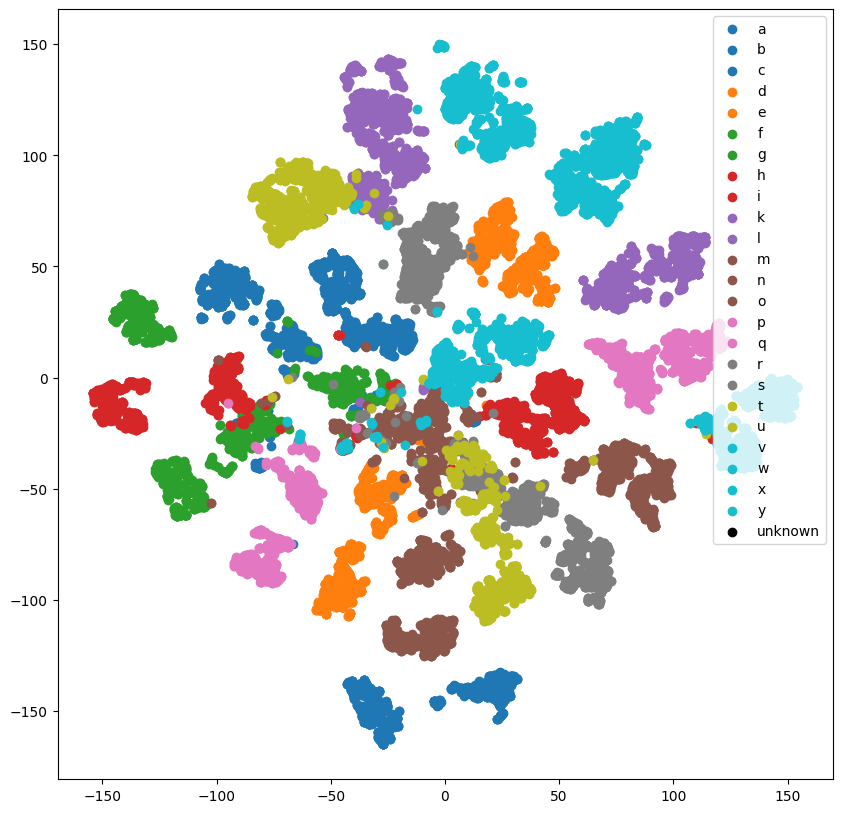

In [18]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.to('cuda')

model = torch.nn.Sequential(*(list(model.children())[:-1]))

model.eval()

features = []
labels = []
for images, target in train_dl:
    images = images.to('cuda')
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names = list(dataset.class_to_idx.keys())

cmap = plt.cm.get_cmap('tab10', len(target_names)-1)

u = False

plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    if target_name != "unknown":
        indices = labels == i
        plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))
plt.scatter(tsne_features[u, 0], tsne_features[u, 1], label="unknown", c="k")
plt.legend()
plt.show()